In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'
os.listdir(FOLDER)

['out', 'structures.csv', 'train.csv']

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
df_structures_idx = df_structures.set_index('molecule_name')
df_train_idx = df_train.set_index('molecule_name')
mols = df_train['molecule_name'].unique()
types_3J = ['3JHH', '3JHC', '3JHN']

In [5]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = ((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

In [6]:
def gen_pairs_list(df_idx, df_structures_idx, molecule_name, type_3J):
    pairs_list = []
    df_tr = df_idx.loc[molecule_name]
    df_st = df_structures_idx.loc[molecule_name]
    if type(df_tr) == pd.Series:
        return []
    
    pairs_3J = df_tr.query('type == "{}"'.format(type_3J))[['atom_index_0','atom_index_1','id']].values
    dist_matrix = get_dist_matrix(df_structures_idx, molecule_name)

    for p3 in pairs_3J:
        atom_idx_0 = p3[0]
        con_id = p3[2]

        dist_arr = dist_matrix[atom_idx_0]
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_1 = masked_idx[np.argsort(dist_arr_excl_0)[0]]

        atom_idx_3 = p3[1]
        dist_arr = dist_matrix[atom_idx_3]
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_2 = masked_idx[np.argsort(dist_arr_excl_0)[0]]        
        
        pair = [atom_idx_0, atom_idx_1, atom_idx_2, atom_idx_3, con_id]
        pairs_list.append(pair)
        
    return pairs_list

In [7]:
def get_cos_3J(df_structures_idx, molecule_name, atom_idx_list):
    pos_list = []
    df_st = df_structures_idx.loc[molecule_name]

    for idx in atom_idx_list:
        pos = df_st.query('atom_index == {}'.format(idx))[['x', 'y', 'z']].values
        pos_list.append(pos)

    v01 = pos_list[1] - pos_list[0]
    v12 = pos_list[2] - pos_list[1]
    v23 = pos_list[3] - pos_list[2]

    v01_12 = v01 - ((np.dot(v01, v12.T) / np.linalg.norm(v12) **2 ) * v12)[0]
    v23_12 = v23 - ((np.dot(v23, v12.T) / np.linalg.norm(v12) **2 ) * v12)[0]
    
    return np.dot(v01_12, v23_12.T) / np.linalg.norm(v01_12) / np.linalg.norm(v23_12)

In [8]:
col_cos = np.zeros(0)
id_arr = np.zeros(0)
start = time.time()
types_3J = ['3JHH', '3JHC', '3JHN']
for m in mols[:10000]:
    df_tr = df_train_idx.loc[m]
    cos_arr = np.zeros([df_tr.shape[0]])
    for t in types_3J:
        pairs_list = gen_pairs_list(df_train_idx, df_structures_idx, m, t)
        if len(pairs_list) == 0:
            continue
        for pair in pairs_list:
            col_cos = np.hstack([col_cos, get_cos_3J(df_structures_idx, m, pair)[0,0]])
            id_arr = np.hstack([id_arr, pair[4]])

se_id = pd.Series(id_arr, name='id', dtype='int')
se_cos = pd.Series(col_cos, name='cos_3j')
df_cos_3j = pd.concat([se_id, se_cos], axis=1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

c:\users\ryoji\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


elapsed_time:2655.785256385803[sec]


In [9]:
df_cos_3j.shape
df_cos_3j.head()

(224295, 2)

In [16]:
df_cos_3j.to_csv(OUTPUT + '20190621_cos_3j.csv', index=False)

In [3]:
# df_cos_3j = pd.read_csv(OUTPUT + '20190621_cos_3j.csv')
# df_cos_3j.head()

,id,cos_3j
0,23,-0.499958
1,24,1.000000
2,25,-0.500033
3,29,1.000000
4,30,-0.499932


In [4]:
id_max = df_cos_3j['id'].max()

In [6]:
id_max

477288

c:\users\ryoji\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\ryoji\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


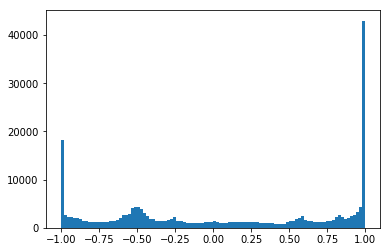

In [10]:
plt.hist(col_cos, bins=100)
plt.show()

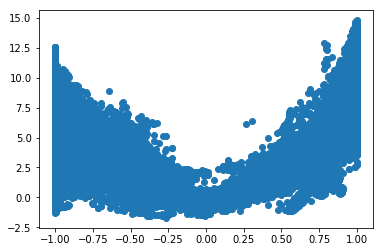

In [15]:
df_temp = pd.merge(df_train, df_cos_3j, on=['id'], how="outer").query('type == "3JHH"').dropna()
plt.scatter(df_temp['cos_3j'], df_temp['scalar_coupling_constant'])
plt.show()

In [7]:
PROCESSED_TRAIN = '20190618_dist_bond_train.csv'
df_train_dist = pd.read_csv(OUTPUT + PROCESSED_TRAIN)

In [10]:
df_train_dist_cos = pd.merge(df_train_dist, df_cos_3j, on=['id'], how="outer").fillna(0)
df_train_dist_cos.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,dist_H_0_x,dist_H_1_x,dist_H_2_x,dist_H_3_x,...,dist_F_1_y,dist_F_2_y,dist_F_3_y,dist_F_4_y,num_bond_F_0_y,num_bond_F_1_y,num_bond_F_2_y,num_bond_F_3_y,num_bond_F_4_y,cos_3j
0,0,dsgdb9nsd_000001,1.0,0.0,1JHC,84.8076,0.314513,0.314503,0.3145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,2.0,0.0,1JHC,84.8074,0.314513,0.314503,0.3145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,3.0,0.0,1JHC,84.8093,0.314503,0.314503,0.3145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,4.0,0.0,1JHC,84.8095,0.314503,0.314503,0.3145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,dsgdb9nsd_000001,1.0,2.0,2JHH,-11.2570,0.314513,0.314503,0.3145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_train_dist_cos.to_csv(OUTPUT + '20190618_dist_bond_cos3j_train.csv', index=False)